# Make Beam for BeamFour

In [52]:
import fortranformat as ff

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import itertools

In [54]:
from astropy import units as u
from astropy.coordinates import Angle

In [55]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# configuration of the Beam

In [56]:
root_filename="Beam4_Rayfile_"

In [57]:
# number of rays
NBEAM_X=11
NBEAM_Y=11
NBEAM=NBEAM_X*NBEAM_Y

In [58]:
Wavelength=np.arange(350,1101,50)
WL=(Wavelength).astype(int)
NWL=len(WL)

In [59]:
WL

array([ 350,  400,  450,  500,  550,  600,  650,  700,  750,  800,  850,
        900,  950, 1000, 1050, 1100])

In [60]:
theta_x=10*u.arcmin # target offset in arcmin
#theta_x=0
theta_y=1*u.arcmin # angle in arcmin 

In [61]:
theta_x_num=int(theta_x*100/u.arcmin)
theta_y_num=int(theta_y*100/u.arcmin)

In [62]:
if theta_x_num>0:
    theta_nstr='{:0>2}'.format(theta_x_num)
    theta_x_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_x_num)
    theta_x_str="m"+theta_nstr

In [63]:
if theta_y_num>0:
    theta_nstr='{:0>2}'.format(theta_y_num)
    theta_y_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_y_num)
    theta_y_str="m"+theta_nstr

In [64]:
Beam4_Rayfile_EXCEL="Beam4_Rayfile_{:d}_nwl{:d}_thx{}_thy{}.xlsx".format(NBEAM,NWL,theta_x_str,theta_y_str)
Beam4_Rayfile_RAY="Beam4_Rayfile_{:d}_nwl{:d}_thx{}_thy{}.RAY".format(NBEAM,NWL,theta_x_str,theta_y_str)

In [65]:
Beam4_Rayfile_EXCEL

'Beam4_Rayfile_121_nwl16_thxp1000_thyp100.xlsx'

In [66]:
Beam4_Rayfile_RAY

'Beam4_Rayfile_121_nwl16_thxp1000_thyp100.RAY'

# configuration of Telescope

In [67]:
Tel_Focal_Length=21.6# m : Focal length of the telescope
Tel_Diameter=1.2# m : Diameter of the telescope  

In [68]:
Tel_Fnum=Tel_Focal_Length/Tel_Diameter

In [69]:
print("Aperture/D =  {} ".format(Tel_Fnum))

Aperture/D =  18.000000000000004 


### distance between the entrance plane and the focal plane

In [70]:
d=200  # here set to be in mm (the BeamFour length units)

# Functions

In [71]:
def EntranceBeamPopulation(nbeamx,nbeamy,f,D,d):
    """
    EntranceBeamPopulation(nbeamx,nbeamy,thetax,thetay,f,D,d)
    
    input arguments :
      - nbeamx : number of beam along x (should be odd, by example 11)
      - nbeamy : number of beam along y (should be odd, by example 11)
      - thetax : central beam angle along x in radian 
      - f : telescope focal length in m
      - D : telescope diameter in m
      - d : distance entrance (beam start) to focal plane. the unit of d is what we want
      
      
    output arguments :
      - return X,Y coordinate of beams relative to central beam (position (0,0)) in same unit as d
    """
    
    numberOfRows = nbeamx*nbeamy
    
    X=np.linspace(-D*d/2/f,D*d/2/f,nbeamx)
    Y=np.linspace(-D*d/2/f,D*d/2/f,nbeamy)
    
    # need to alloc memory for the dataframe
    df=pd.DataFrame(index=np.arange(0, numberOfRows),columns=['id','nx', 'ny', 'X0','Y0'])
    
    idx=0
    for ny in np.arange(len(Y)):
        for nx in np.arange(len(X)):         
            df.iloc[idx]= [idx+1, nx,ny,X[nx],Y[ny]]
            idx+=1
            
    
    return df
    

In [72]:
def ComputeAngles(df_in,alphax,alphay,d):
    """
    ComputeAngles(df_in,thetax,thetay,d)
    
    * input argument
      - df_in
      - thetax,thetay angles in radians
      - d : distance entrance -focal point
      
    * output argument
      -df
    
    
    """
    tan_alphax_0=np.tan(alphax)
    tan_alphay_0=np.tan(alphay)
    x=np.asarray(df_in["X0"].values).astype(np.float64)
    y=np.asarray(df_in["Y0"].values).astype(np.float64)
    
    tan_alphax=np.array(tan_alphax_0-x/d)
    tan_alphay=np.array(tan_alphay_0-y/d)
    
    
    Uz=1./(np.sqrt(1.+tan_alphax**2+tan_alphay**2))
    Ux=tan_alphax*Uz
    Uy=tan_alphay*Uz
    
    df=df_in
    df["U0"]=Ux
    df["V0"]=Uy
    df["W0"]=Uz
    
    return df
    
    
    

In [73]:
def SimulateSquareBeam(nbeamx,nbeamy,thetax,thetay,f,D,d):
    """
    SimulateSquareBeam(nbeamx,nbeamy,thetax,thetay,f,D,d)
    
    input arguments :
      - nbeamx : number of beam along x (should be odd, by example 11)
      - nbeamy : number of beam along y (should be odd, by example 11)
      - thetax : central beam angle along x in radian 
      - f : telescope focal length in m
      - D : telescope diameter in m
      - d : distance entrance (beam start) to focal plane   
    """

# compute

## repartition of beams at entrance

In [74]:
df=EntranceBeamPopulation(NBEAM_X,NBEAM_Y,Tel_Focal_Length,Tel_Diameter,d)

In [75]:
len(df)

121

In [76]:
df

,id,nx,ny,X0,Y0
0,1,0,0,-5.55556,-5.55556
1,2,1,0,-4.44444,-5.55556
2,3,2,0,-3.33333,-5.55556
3,4,3,0,-2.22222,-5.55556
4,5,4,0,-1.11111,-5.55556
...,...,...,...,...,...
116,117,6,10,1.11111,5.55556
117,118,7,10,2.22222,5.55556
118,119,8,10,3.33333,5.55556
119,120,9,10,4.44444,5.55556


## Orientation of beams

In [77]:
alpha_x=Angle(theta_x)
alpha_y=Angle(theta_y)

In [78]:
df=ComputeAngles(df,alpha_x.radian,alpha_y.radian,d)

In [79]:
df

,id,nx,ny,X0,Y0,U0,V0,W0
0,1,0,0,-5.55556,-5.55556,0.030660,0.028044,0.999136
1,2,1,0,-4.44444,-5.55556,0.025113,0.028049,0.999291
2,3,2,0,-3.33333,-5.55556,0.019564,0.028052,0.999415
3,4,3,0,-2.22222,-5.55556,0.014013,0.028055,0.999508
4,5,4,0,-1.11111,-5.55556,0.008461,0.028057,0.999571
...,...,...,...,...,...,...,...,...
116,117,6,10,1.11111,5.55556,-0.002646,-0.027476,0.999619
117,118,7,10,2.22222,5.55556,-0.008199,-0.027476,0.999589
118,119,8,10,3.33333,5.55556,-0.013751,-0.027474,0.999528
119,120,9,10,4.44444,5.55556,-0.019302,-0.027471,0.999436


### check the calculation of directions 

In [80]:
# compute the norm
df.apply(lambda x: np.sqrt(x.U0**2+x.V0**2+x.W0**2), axis=1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
116    1.0
117    1.0
118    1.0
119    1.0
120    1.0
Length: 121, dtype: float64

### beams at entrance

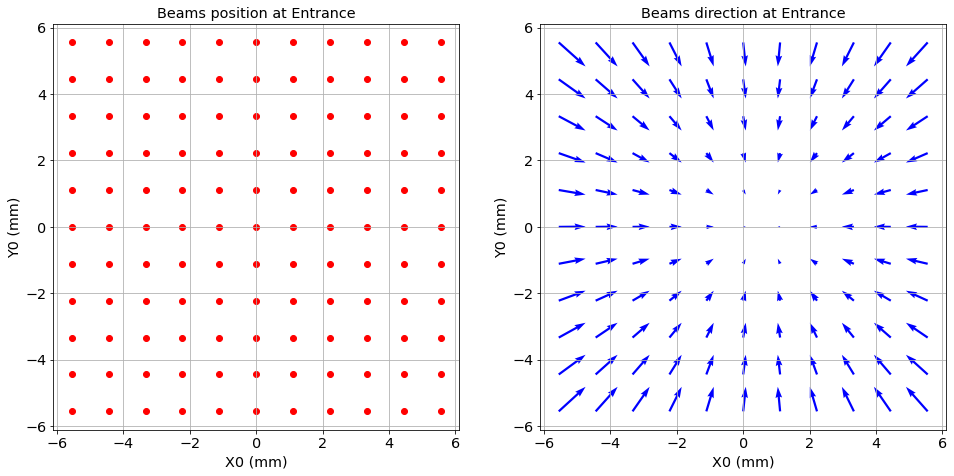

In [89]:
fig=plt.figure(figsize=(16,8))

ax=fig.add_subplot(121)
ax.scatter(df["X0"].values,df["Y0"].values,color="r")
ax.grid()
ax.set_xlabel("X0 (mm)")
ax.set_ylabel("Y0 (mm)")
ax.set_title("Beams position at Entrance")
ax.set_aspect('equal')


ax=fig.add_subplot(122)
X=np.asarray(df["X0"].values).astype(np.float64)
Y=np.asarray(df["Y0"].values).astype(np.float64)
U=np.asarray(df["U0"].values).astype(np.float64)
V=np.asarray(df["V0"].values).astype(np.float64)

ax.quiver(X,Y,U,V,color="b")
ax.grid()
ax.set_xlabel("X0 (mm)")
ax.set_ylabel("Y0 (mm)")
ax.set_title("Beams direction at Entrance")
ax.set_aspect('equal')


## Compute focal point position ad Z=d

In [82]:
df["X1"]=df.apply(lambda x: (x.X0+d*x.U0/x.W0), axis=1)
df["Y1"]=df.apply(lambda x: (x.Y0+d*x.V0/x.W0), axis=1)
df["Z1"] = d

In [83]:
df

,id,nx,ny,X0,Y0,U0,V0,W0,X1,Y1,Z1
0,1,0,0,-5.55556,-5.55556,0.030660,0.028044,0.999136,0.581778,0.058178,200
1,2,1,0,-4.44444,-5.55556,0.025113,0.028049,0.999291,0.581778,0.058178,200
2,3,2,0,-3.33333,-5.55556,0.019564,0.028052,0.999415,0.581778,0.058178,200
3,4,3,0,-2.22222,-5.55556,0.014013,0.028055,0.999508,0.581778,0.058178,200
4,5,4,0,-1.11111,-5.55556,0.008461,0.028057,0.999571,0.581778,0.058178,200
...,...,...,...,...,...,...,...,...,...,...,...
116,117,6,10,1.11111,5.55556,-0.002646,-0.027476,0.999619,0.581778,0.058178,200
117,118,7,10,2.22222,5.55556,-0.008199,-0.027476,0.999589,0.581778,0.058178,200
118,119,8,10,3.33333,5.55556,-0.013751,-0.027474,0.999528,0.581778,0.058178,200
119,120,9,10,4.44444,5.55556,-0.019302,-0.027471,0.999436,0.581778,0.058178,200
